# Get boxes in CONUS and South America
jjhenao May 2025 @ digital-earths-global-hackathon

In [31]:
import intake
import easygems.healpix as egh
from easygems.healpix import attach_coords
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
import pickle
import os
warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
# open the catalog from NCAR, change to online if remote
current_location = "NCAR"
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[current_location]

In [8]:
# load dataset at desired zoom and attach coords
dummy_ds = cat["scream2D_hrly"](zoom=8).to_dask()
dummy_ds = attach_coords(dummy_ds)

<Figure size 640x480 with 0 Axes>

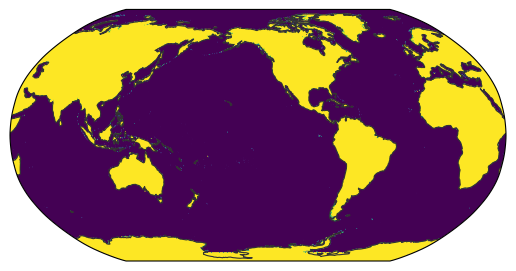

In [9]:
# plot land fraction - used to get the part in land only
egh.healpix_show(dummy_ds["LANDFRAC"])

In [5]:
# Subset data for SA and CONUS domains
us_lat_min = 20
us_lat_max = 55
us_lon_min = 220
us_lon_max = 304

In [10]:
# lon converter (just for me, can't think in 0-360 lon)
lon = -68
lon_360 = (lon + 360) % 360
print(lon_360)

292


In [11]:
"""
masks for selected regions
based on https://easy.gems.dkrz.de/Processing/healpix/Land_sea_mask.html
"""


def land(ds):
    return ds.LANDFRAC == 1


def ocean(ds):
    return ds.LANDFRAC == 0


def amazon(ds):
    return (
        (ds.lat >= -10) & (ds.lat <= 3) &
        (ds.lon >= 292) & (ds.lon <= 310) & land(ds)
    )


def colombia(ds):
    return (
        (ds.lat >= -2) & (ds.lat <= 13) &
        (ds.lon >= 280) & (ds.lon <= 300) & land(ds)
    )


def argent(ds):
    return (
        (ds.lat >= -35) & (ds.lat <= -18) &
        (ds.lon >= 293) & (ds.lon <= 320) & land(ds)
    )


def western(ds):
    return (
        (ds.lat >= 32) & (ds.lat <= 48) & (ds.lon >= 235) &
        (ds.lon <= 255) & land(ds)
    )


def central(ds):
    return (
        (ds.lat >= 30) & (ds.lat <= 48) & (ds.lon >= 256) &
        (ds.lon <= 280) & land(ds)
    )

In [17]:
%%time

# filter for the region area, time 10 is just as an example
cen_land = dummy_ds['pr'].where(central(dummy_ds).compute(), drop=True).isel(time=10)
wes_land = dummy_ds['pr'].where(western(dummy_ds).compute(), drop=True).isel(time=10)
col_land = dummy_ds['pr'].where(colombia(dummy_ds).compute(), drop=True).isel(time=10)
arg_land = dummy_ds['pr'].where(argent(dummy_ds).compute(), drop=True).isel(time=10)
ama_land = dummy_ds['pr'].where(amazon(dummy_ds).compute(), drop=True).isel(time=10)

regions = [col_land, arg_land, ama_land, wes_land, cen_land]

CPU times: user 1.3 s, sys: 179 ms, total: 1.48 s
Wall time: 1.3 s


In [33]:
# get the cell values for each region 
# add it to a dictionary and save it

cell_regions = {
    "central_us": cen_land.cell.values,
    "western_us": wes_land.cell.values,
    "northern_sa": col_land.cell.values,
    "amazon": ama_land.cell.values,
    "argentina": arg_land.cell.values,
}

dir = '/glade/derecho/scratch/jhenao/'
os.makedirs(dir, exist_ok = True)

with open(dir+"region_healpix_cells_zoom8.pkl", "wb") as f:
    pickle.dump(cell_regions, f)

<Figure size 640x480 with 0 Axes>

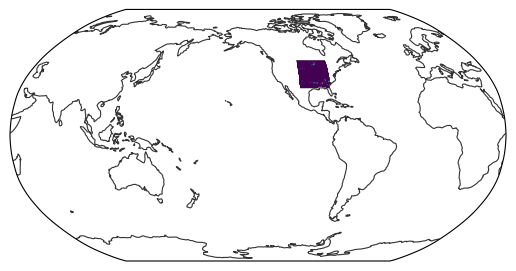

In [30]:
# for example

pr_central = dummy_ds['pr'].sel(cell = cen_land.cell.values).isel(time=-1)

egh.healpix_show(pr_central)

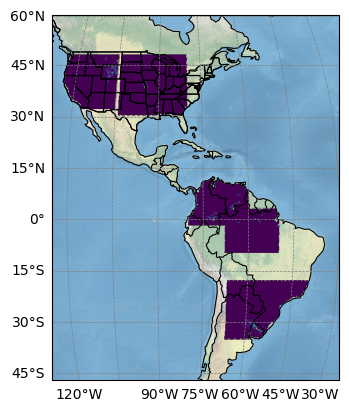

In [67]:
# plotting all regions together

lon_min = -125
lon_max = -30
lat_min = -36
lat_max = 50

projection = ccrs.Robinson(central_longitude=-85)

fig, ax = plt.subplots(
    figsize=(8, 4), 
    subplot_kw={"projection": projection}, 
    constrained_layout=True
)


ax.set_global()
ax.set_extent([lon_min, lon_max, lat_min, lat_max]) 

ax.stock_img()
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.STATES, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)


#plot regions
for region in regions:
    egh.healpix_show(region, cmap='viridis')
    
# Add gridlines with latitude and longitude labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
gl.xlocator = plt.MaxNLocator(integer=True)
gl.ylocator = plt.MaxNLocator(integer=True)
gl.top_labels = False  
gl.right_labels = False

plt.show()
